Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
# import numpy as np
# import pandas as pd

# # Read New York City apartment rental listing data
# df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
# assert df.shape == (49352, 34)

# # Remove the most extreme 1% prices,
# # the most extreme .1% latitudes, &
# # the most extreme .1% longitudes
# df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
#         (df['price'] <= np.percentile(df['price'], 99.5)) & 
#         (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
#         (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
#         (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
#         (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

import numpy as np 
import pandas as pd 

def readin(filepath):
    # Read in data, apply instructor filtering, return bas df
    df = pd.read_csv(DATA_PATH+filepath)

    df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

    return df

def wrangle(filepath):
    # Read in the data, apply initial instructor filtering
    df = readin(filepath)

    # Change 'created' to datetime objects and set index to 'created'
    df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
    df.set_index(keys='created', inplace=True)
    
    # Drop high cardinatlity columns
    high_cardinality = [col for col in df.select_dtypes('object').columns 
                         if df[col].nunique() > 12]
    df.drop(columns=high_cardinality, inplace=True)

    ## Create new features
    # Total amenities
    columns = df.columns[6:]
    df['total_amenities'] = df[columns].sum(axis=1)

    # Dogs or cats
    #df['dogs_or_cats'] = (df['dogs_allowed'] == 1) | (df['cats_allowed'] == 1) # Returns Boolean
    df.loc[(df['dogs_allowed'] == 1) | (df['cats_allowed'] == 1), 'dogs_or_cats'] = 1
    df.loc[(df['dogs_allowed'] == 0) & (df['cats_allowed'] == 0), 'dogs_or_cats'] = 0 

    # Dogs and cats
    #df['dogs_and_cats'] = (df['dogs_allowed'] == 1) & (df['cats_allowed'] == 1) # Returns Boolean
    df.loc[(df['dogs_allowed'] == 1) & (df['cats_allowed'] == 1), 'dogs_and_cats'] = 1 
    df.loc[(df['dogs_allowed'] == 0) | (df['cats_allowed'] == 0), 'dogs_and_cats'] = 0 

    # Total rooms, bath and bedrooms
    df['total_rooms'] = df['bathrooms'] + df['bedrooms']

    # Ratio of beds to baths
    df['beds_to_baths'] = df['bedrooms'] / df['bathrooms']

    # Final DataFrame with features to use for model 
    df_small = df[['bathrooms', 'total_rooms', 'longitude', 'price']].copy()

    return df_small

train = wrangle('apartments/renthop-nyc.csv')
print(train.shape)
train.head()

(48817, 4)


,bathrooms,total_rooms,longitude,price
created,,,,
2016-06-24 07:54:24,1.5,4.5,-73.9425,3000
2016-06-12 12:19:27,1.0,3.0,-73.9667,5465
2016-04-17 03:26:41,1.0,2.0,-74.0018,2850
2016-04-18 02:22:02,1.0,2.0,-73.9677,3275
2016-04-28 01:32:41,1.0,5.0,-73.9493,3350


In [4]:
for col in train.select_dtypes('object').columns:
    print(f'Cardinality for {col}:', train[col].nunique())

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    48817 non-null  float64
 1   total_rooms  48817 non-null  float64
 2   longitude    48817 non-null  float64
 3   price        48817 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 1.9 MB


In [6]:
# Split the data into a Feature Matrix and a Target Array

target = 'price'

y = train[target]
X = train.drop(columns=target)

print(X.shape, y.shape)
print(X.head())

(48817, 3) (48817,)
                     bathrooms  total_rooms  longitude
created                                               
2016-06-24 07:54:24        1.5          4.5   -73.9425
2016-06-12 12:19:27        1.0          3.0   -73.9667
2016-04-17 03:26:41        1.0          2.0   -74.0018
2016-04-18 02:22:02        1.0          2.0   -73.9677
2016-04-28 01:32:41        1.0          5.0   -73.9493


In [7]:
# Split the data into train and test sets

mask = X.index < '2016-06-01'

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

display(X_train.tail())

,bathrooms,total_rooms,longitude
created,,,
2016-04-22 15:44:11,1.0,2.0,-73.9869
2016-04-04 18:22:34,1.0,2.0,-74.0163
2016-04-16 02:13:40,1.0,2.0,-73.9900
2016-04-08 02:13:33,1.0,1.0,-74.0101
2016-04-12 02:48:07,1.0,3.0,-73.9172


In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(31844, 3) (31844,)
(16973, 3) (16973,)


In [9]:
# Establish a baseline to beat

print('Mean Baseline (using 0 features)')
guess = y_train.mean()
print (f'{guess:,.2f}')

Mean Baseline (using 0 features)
3,575.60


In [10]:
# Baseline MAE

y_pred = [guess] * len(y_train)

mae = mean_absolute_error(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred, squared=False)
r2 = r2_score(y_train, y_pred)

print('Baseline MAE using mean baseline (0 features): ${:,.2f}'.format(mae))
print('Baseline RMSE using mean baseline (0 features): ${:,.2f}'.format(rmse))
print('Baseline R_squared using mean baseline (0 features): ${:,.2f}'.format(r2))

Baseline MAE using mean baseline (0 features): $1,201.88
Baseline RMSE using mean baseline (0 features): $1,762.11
Baseline R_squared using mean baseline (0 features): $0.00


In [11]:
model_lr = LinearRegression()

In [12]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [13]:
# Apply model to the training data
y_pred = model_lr.predict(X_train)

In [14]:
mae = mean_absolute_error(y_train, y_pred)
remse = mean_squared_error(y_train, y_pred, squared=False)
r2 = r2_score(y_train, y_pred)

print('Model training MAE using 2 features: {:.2f}'.format(mae))
print('Model training RMSE using 2 features: {:.2f}'.format(rmse))
print('Model training R_squared using 2 features: {:.2f}'.format(r2))

Model training MAE using 2 features: 737.42
Model training RMSE using 2 features: 1762.11
Model training R_squared using 2 features: 0.58


In [15]:
beta_0 = model_lr.intercept_
beta_1 = model_lr.coef_[0]
beta_2 = model_lr.coef_[1]
beta_3 = model_lr.coef_[2]

print(beta_0, beta_1, beta_2, beta_3)

-1146190.1255217432 1582.1305560038165 426.28859761737203 -15501.584142974305


In [16]:
equation = (
    f'Rent = {beta_0:,.2f} + '
    f'{beta_1:,.2f}*bathrooms +'
    f'{beta_2:,.2f}*bedrooms '
    f'{beta_3:,.2f}*longitude'
)

print(equation)

Rent = -1,146,190.13 + 1,582.13*bathrooms +426.29*bedrooms -15,501.58*longitude


In [17]:
mae = mean_absolute_error(y_test, model_lr.predict(X_test))
rmse = mean_squared_error(y_test, model_lr.predict(X_test), squared=False)
r2 = r2_score(y_test, model_lr.predict(X_test))

In [18]:
print('Model test MAE using 2 features: {:.2f}'.format(mae))
print('Model test RMSE using 2 features: {:.2f}'.format(rmse))
print('Model test R_squared using 2 features: {:.2f}'.format(r2))

Model test MAE using 2 features: 743.53
Model test RMSE using 2 features: 1134.19
Model test R_squared using 2 features: 0.59


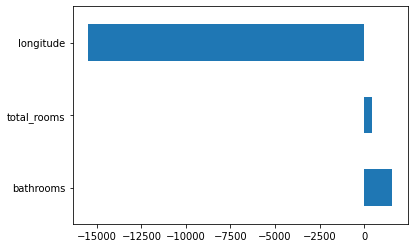

In [19]:
pd.Series(model_lr.coef_, index=X_train.columns).plot(kind='barh');